In [1]:
from collections import Counter, defaultdict
import itertools

import gc
from joblib import Parallel, delayed
# import limix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import pickle
import scipy.stats as sps
import seaborn as sns
import statsmodels.stats.multitest as multitest
from tqdm import tqdm_notebook

gc.enable()
sns.set()
sns.set_style({"font.family" : "serif"})

%matplotlib inline

In [2]:
# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import multiprocessing as mp
import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

In [3]:
# custom modules
%aimport util
%aimport qtls

In [4]:
expression_df = {
    "mRNA_2011" : pd.read_csv("data/raw/eQTLs/2011/expression.csv", sep='\t'),
    "mRNA_2018" : pd.read_csv("data/raw/eQTLs/2018/expression.csv", sep='\t'),
    "protein_2011" : pd.read_csv("data/raw/pQTLs/2011/expression.csv", sep='\t')
}
genotypes_df = {
    "2011" : pd.read_csv("data/raw/eQTLs/2011/genotypes.csv", sep='\t'),
    "2018" : pd.read_csv("data/raw/eQTLs/2018/genotypes_filtered.csv", sep='\t')
}
covariates_df = {"2018" : pd.read_csv("data/raw/eQTLs/2018/covariates_A&B.csv", sep='\t')}
qtls_df = {
    "eQTLs_2011" : pd.read_csv("data/processed/eQTLs/2011/qtls_naive.csv", sep='\t'),
    "eQTLs_2018" : pd.read_csv("data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv", sep='\t'),
    "pQTLs_2011" : pd.read_csv("data/processed/pQTLs/2011/qtls_naive.csv", sep='\t')
}

I tried to use `limix.qtl.mt_scan` as prescribed in [official documentation](https://limix.readthedocs.io/en/stable/qtl.html#multi-trait-association), but it fails with cryptic warnings throwing from within `scipy.linalg`. I have no idea why this happens, I am going to submit an issue. So far I am forced to process the features one-by-one. And still, many questions arise. 

Nevertheless, this package works like a charm compared to the mess provided by Albert and Bloom.

## General questions

* How to choose the `lik` parameter of `limix.qtl.st_scan`? It stands for the residual distribution in generalized linear model. Documentation states, that `lik` value must be set prior to the fitting of the model, but the very choice of an underlying statistical model is specified by the `lik` value... Sounds like a vicious circle. I decided to go on with the default `lik` value — _normal_, but I don't feel right for not carrying out any in-depth statistical analysis that could justify this choice.
* Same questions about the `K` parameter. It seems to be some kind of relatedness matrix. They provide several functions for its inference, such as `limix.stats.linear_kinship` ([manual](https://limix.readthedocs.io/en/stable/stats.html?highlight=linear_kinship)), but without describing the underlying algorithm. It's worth sending them a literature request.

In [260]:
class LimixQTLMapper():
    def __init__(self, G, Y, # essential model parameters
                 kind, gene_list, marker_list, # data specification
                 M=None, K=None, lik="normal", # model parameters
                 batch_size=512, thresh=0.05): # map-reduce parameters
        self.G = G
        self.Y = Y
        self.M = M
        self.K = K
        
        self.gene_list = gene_list
        self.marker_list = marker_list
        
        self.batch_size = batch_size
        self.kind = kind
        self.lik = lik
        self.thresh = thresh
        
    @staticmethod
    def _get_raw_pvalues(**st_scan_kwargs):
        return limix.qtl.st_scan(**st_scan_kwargs).variant_pvalues
    
    @staticmethod
    def _adjust_pvalues(raw_pvalues):
        return limix.stats.multipletests(raw_pvalues, method="holm")[1]
    
    @staticmethod
    def _filter_significant(raw_pvalues, thresh):
        return np.where(raw_pvalues < thresh)[0]
    
    def map(self):
        n_genes = self.Y.shape[1]
        for i in np.arange(0, n_genes, self.batch_size):
            raw_pvalues_batch = np.vstack(
                Parallel(n_jobs=-1)
                (delayed(LimixQTLMapper._get_raw_pvalues)
                 (G=self.G, y=self.Y[:, gene_idx], 
                  K=self.K, M=self.M, 
                  lik=self.lik, verbose=False)
                 
                 for gene_idx 
                 in tqdm_notebook(np.arange(n_genes)
                                  [i:min(i + self.batch_size, n_genes)], 
                                  desc=("getting raw p-values, batch {} out of {}"\
                                        .format(i // self.batch_size, 
                                                np.ceil(n_genes / self.batch_size).astype(np.int32))))
                )
            )
            
            path_to_dump = ("data/tmp/limix/" 
                            + self.kind
                            + "_p_raw_{}.pkl".format(i))
            
            with open(path_to_dump, "wb") as outfile:
                pickle.dump(raw_pvalues_batch, outfile)

            del raw_pvalues_batch
            gc.collect()
            
    def reduce(self, recompute=False):
        raw_pvalues = None
        n_genes = Y.shape[1]
        for i in tqdm_notebook(range(0, n_genes, self.batch_size), 
                               desc="loading p-value batches"):
            
            path_to_batch_dump = ("data/tmp/limix/" 
                                  + self.kind
                                  + "_p_raw_{}.pkl".format(i))
            
            with open(path_to_batch_dump, "rb") as infile:
                raw_pvalues_batch = pickle.load(infile)
                
            raw_pvalues = (np.vstack((raw_pvalues, raw_pvalues_batch)) 
                           if raw_pvalues is not None
                           else raw_pvalues_batch)
        if recompute: 
            with open(("data/tmp/limix/" 
                       + self.kind
                       + "_p_raw.pkl"), "wb") as outfile:
                pickle.dump(raw_pvalues, outfile)
                
        adjusted_pvalues = Parallel(n_jobs=-1)(
            delayed(LimixQTLMapper._adjust_pvalues)(row) 
            for row in tqdm_notebook(raw_pvalues, 
                                     desc="p-value adjustment")
        )
        
        if recompute:
            with open(("data/tmp/limix/" 
                       + self.kind 
                       + "_p_adjusted.pkl"), "wb") as outfile:
                pickle.dump(adjusted_pvalues, outfile)
            
        limix_qtls = Parallel(n_jobs=-1)(
            delayed(LimixQTLMapper._filter_significant)(row, self.thresh) 
            for row in tqdm_notebook(adjusted_pvalues, 
                                     desc="p-value filtering")
        )
        
        indices = [(i, j) 
                   for i in range(n_genes) 
                   for j in limix_qtls[i]]
            
        self.limix_qtls_df = pd.DataFrame(
            [(self.gene_list[i], 
              self.marker_list[j], 
              raw_pvalues[i][j],
              adjusted_pvalues[i][j])
             for i, j in tqdm_notebook(indices, 
                                       desc="dataframe formation")
            ], columns=["gene", "SNP", "p_value", "q_value"])
        
        return self.limix_qtls_df
    
    def map_reduce(self, recompute=True):
        self.map()
        return self.reduce(recompute=recompute)

## 2018, paper of Albert&Bloom

In [253]:
# G = (genotypes_df["2018"].drop(columns=["SNP"]).iloc[:, :-2].values).T // 2
# G[np.isnan(G)] = 2
# Y = (expression_df["mRNA_2018"].drop(columns=["gene"]).astype(np.float32).values).T
# Y = limix.qc.mean_impute(Y)
# C = covariates_df["2018"].drop(columns=["segregant"]).values
# C = np.column_stack((np.ones(C.shape[0]), C))
# K = limix.stats.linear_kinship(G)
# assert G.shape[0] == Y.shape[0] == C.shape[0]












Kinship:   0%|          | 0/101 [00:00<?, ?it/s]










Kinship:  19%|█▉        | 19/101 [00:00<00:00, 189.15it/s]










Kinship:  41%|████      | 41/101 [00:00<00:00, 196.51it/s]










Kinship:  63%|██████▎   | 64/101 [00:00<00:00, 204.19it/s]










Kinship:  84%|████████▍ | 85/101 [00:00<00:00, 205.48it/s]










Kinship: 100%|██████████| 101/101 [00:00<00:00, 210.39it/s]

In [261]:
# limix_mapper = LimixQTLMapper(
#     G=G, Y=Y, K=K, M=C, kind="A&B_eQTLs_2018",
#     gene_list=expression_df["mRNA_2018"]["gene"],
#     marker_list=genotypes_df["2018"]["SNP"],
#     thresh=1e-3
# )
# limix_qtls_df = limix_mapper.reduce()

In [263]:
# limix_qtls_df.to_csv("data/processed/eQTLs/2018/qtls_limix.csv", 
#                      sep='\t', index=False)

In [42]:
limix_qtls_df = pd.read_csv("data/processed/eQTLs/2018/qtls_limix.csv", sep='\t')

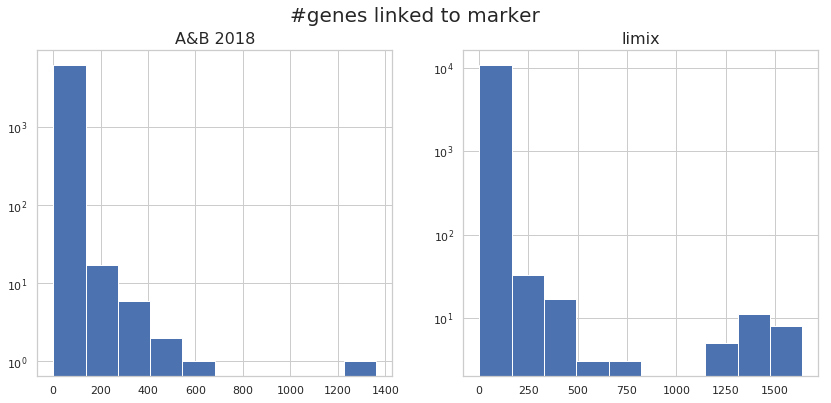

In [43]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(14, 6))
fig.suptitle("#genes linked to marker", fontsize=20)
axes = [plt.subplot(gs[i]) for i in range(2)]

axes[0].hist(Counter(qtls_df["eQTLs_2018"]["SNP"]).values());
axes[0].set_title("A&B 2018", fontsize=16)
axes[0].set_yscale("log")

axes[1].hist(Counter(limix_qtls_df["SNP"]).values())
axes[1].set_title("limix", fontsize=16)
axes[1].set_yscale("log")

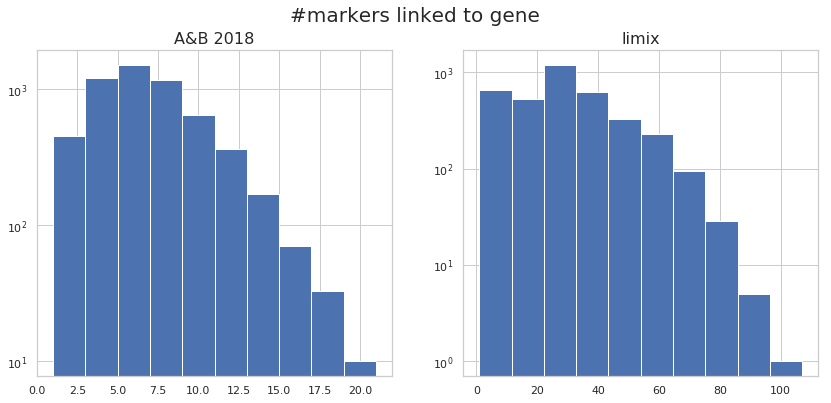

In [44]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(14, 6))
fig.suptitle("#markers linked to gene", fontsize=20)

axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].hist(Counter(qtls_df["eQTLs_2018"]["gene"]).values());
axes[0].set_title("A&B 2018", fontsize=16)
axes[0].set_yscale("log")

axes[1].hist(Counter(limix_qtls_df["gene"]).values())
axes[1].set_title("limix", fontsize=16)
axes[1].set_yscale("log")

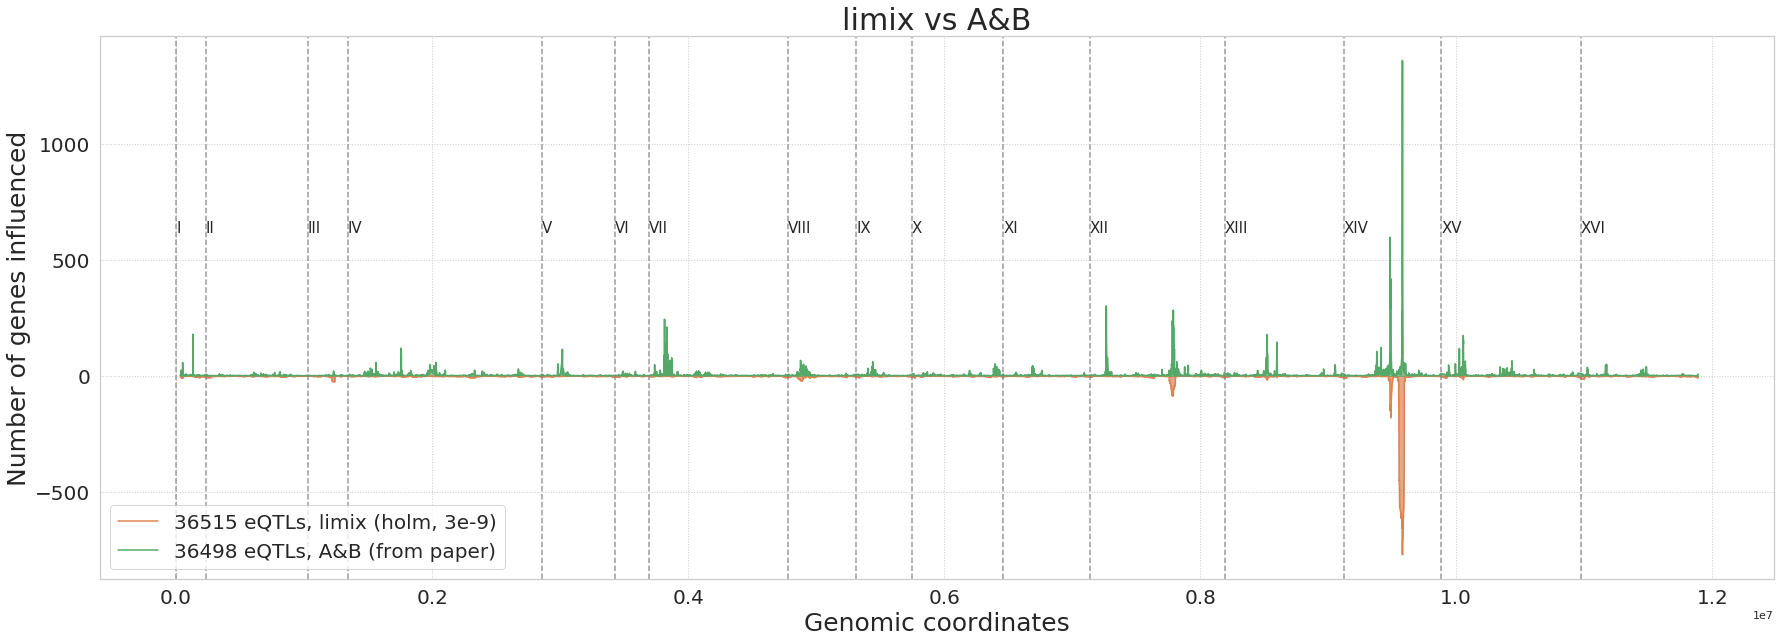

In [45]:
""" Plot the distributions of each QTL dataset"""

sns.set(style="whitegrid")


with open("./data/raw/genomic_features/order_of_markers.pkl", "rb") as pickle_file:
    marker2location = pickle.load(pickle_file)
with open("./data/raw/genomic_features/chromosome_endpoints.pkl",
          "rb") as pickle_file:
    chromosome_endpoints = pickle.load(pickle_file)

limix_eQTLs_2018 = limix_qtls_df.query("q_value <= 3e-9")
limix_eQTL_markers, limix_eQTL_y = qtls.linkages2gencoords(limix_eQTLs_2018)
new_eQTL_markers, new_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_2018"])

new_eQTL_x = list(map(marker2location.get, new_eQTL_markers))
limix_eQTL_x = list(map(marker2location.get, limix_eQTL_markers))

colors_dict = dict(
    zip([
        "eQTLs_2011", "eQTLs_limix", "eQTLs_2018"
    ], plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]))

colors_dict["pQTLs_2011"] = "black"
plt.figure(figsize=(30, 10))
plt.title(
    "limix vs A&B",
    fontsize=30)
for n in range(1, 17):
    plt.axvline(
        x=chromosome_endpoints[n - 1], linestyle='--', color='grey', alpha=0.8)
    plt.text(
        chromosome_endpoints[n - 1],
        0.8 * np.max(limix_eQTL_y),
        util.as_roman(n),
        fontsize=15)

plt.plot(
    limix_eQTL_x,
    -limix_eQTL_y,
    label="{} eQTLs, limix (holm, 3e-9)".format(limix_eQTLs_2018.shape[0]),
    alpha=1,
    color=colors_dict["eQTLs_limix"],
    zorder=1)
plt.fill_between(
    limix_eQTL_x, 
    -limix_eQTL_y, 0, 
    alpha=0.7, 
    color=colors_dict["eQTLs_limix"]
)

plt.plot(
    new_eQTL_x,
    new_eQTL_y,
    label="{} eQTLs, A&B (from paper)".format(qtls_df["eQTLs_2018"].shape[0]),
    alpha=1,
    color=colors_dict["eQTLs_2018"],
    zorder=1)
plt.fill_between(
    new_eQTL_x, 0, new_eQTL_y, alpha=0.7, color=colors_dict["eQTLs_2018"]
)

plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of genes influenced", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc=3)
plt.grid(linestyle="dotted")
# plt.savefig("img/qtl_distributions/corrected_limix_vs_A&B_2018.png", dpi=300)
plt.show()
plt.close()

## 2011, our mRNA dataset

In [265]:
# G = (genotypes_df["2011"].drop(columns=["SNP", "chromosome", "position"])).values.T // 2
# G[np.isnan(G)] = 2
# Y = (expression_df["mRNA_2011"].drop(columns=["gene"]).astype(np.float32).values).T
# Y = limix.qc.mean_impute(Y)
# assert G.shape[0] == Y.shape[0]

In [266]:
# limix_mapper = LimixQTLMapper(
#     G=G, Y=Y, K=K, kind="naive_eQTLs_2011",
#     gene_list=expression_df["mRNA_2011"]["gene"],
#     marker_list=genotypes_df["2011"]["SNP"],
#     batch_size=Y.shape[1]
# )
# limix_qtls_df = limix_mapper.reduce(recompute=True)

In [267]:
# limix_qtls_df.to_csv("data/processed/eQTLs/2011/qtls_limix.csv", 
#                      sep='\t', index=False)

In [55]:
limix_qtls_df = pd.read_csv("data/processed/eQTLs/2011/qtls_limix.csv", sep='\t')

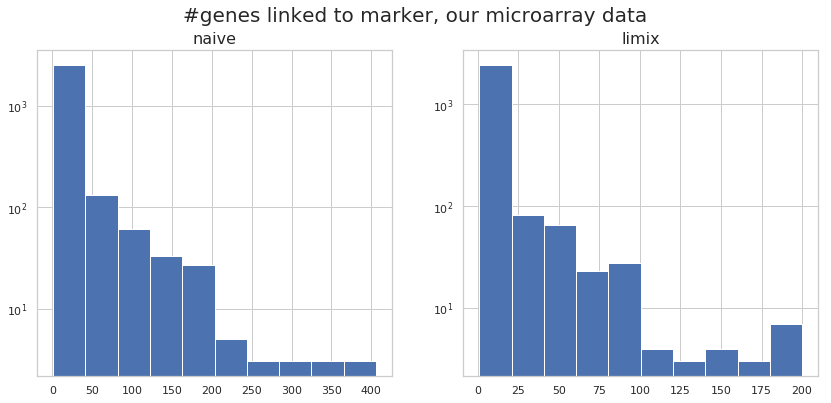

In [56]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(14, 6))
fig.suptitle("#genes linked to marker, our microarray data", fontsize=20)
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].hist(Counter(qtls_df["eQTLs_2011"]["SNP"]).values());
axes[0].set_title("naive", fontsize=16)
axes[0].set_yscale("log")
axes[1].hist(Counter(limix_qtls_df["SNP"]).values())
axes[1].set_title("limix", fontsize=16)
axes[1].set_yscale("log")

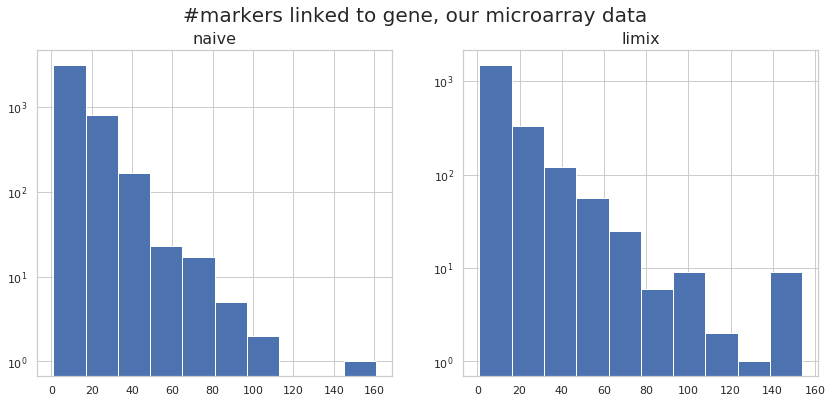

In [57]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(14, 6))
fig.suptitle("#markers linked to gene, our microarray data", fontsize=20)
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].hist(sorted(Counter(qtls_df["eQTLs_2011"]["gene"]).values())[:-4]);
axes[0].set_title("naive", fontsize=16)
axes[0].set_yscale("log")
axes[1].hist(Counter(limix_qtls_df["gene"]).values())
axes[1].set_title("limix", fontsize=16)
axes[1].set_yscale("log")

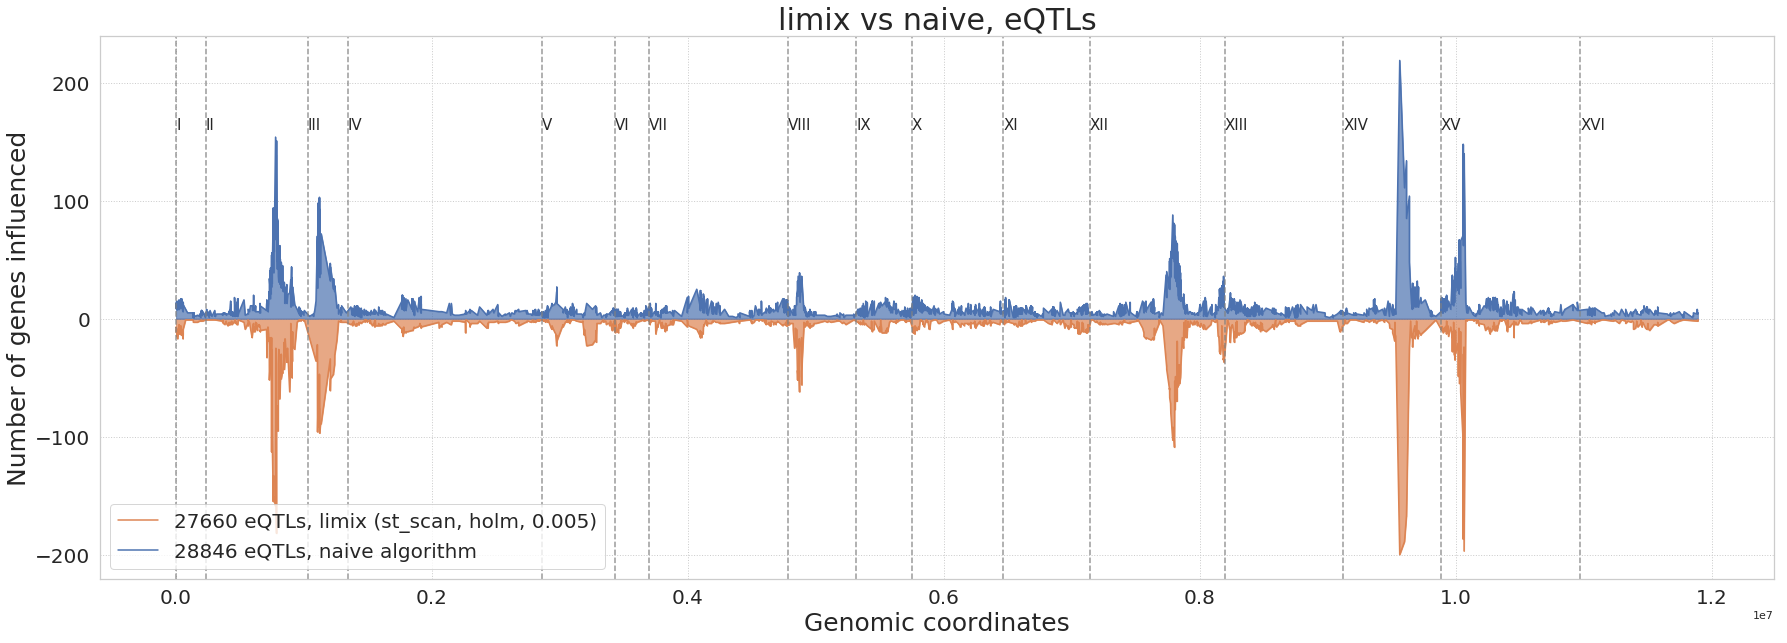

In [58]:
""" Plot the distributions of each QTL dataset"""

sns.set(style="whitegrid")

q_value_threshold = 5e-3
with open("./data/raw/genomic_features/order_of_markers.pkl", "rb") as pickle_file:
    marker2location = pickle.load(pickle_file)
with open("./data/raw/genomic_features/chromosome_endpoints.pkl",
          "rb") as pickle_file:
    chromosome_endpoints = pickle.load(pickle_file)
    
limix_eQTLs_2011 = limix_qtls_df
limix_eQTL_markers, limix_eQTL_y = qtls.linkages2gencoords(limix_qtls_df)
old_eQTL_markers, old_eQTL_y = qtls.linkages2gencoords(
    qtls_df["eQTLs_2011"]\
    .query("q_value <= {}"\
           .format(q_value_threshold))
)

old_eQTL_x = list(map(marker2location.get, old_eQTL_markers))
limix_eQTL_x = list(map(marker2location.get, limix_eQTL_markers))

colors_dict = dict(
    zip([
        "eQTLs_2011", "eQTLs_limix", "eQTLs_2018"
    ], plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]))

colors_dict["pQTLs_2011"] = "black"
plt.figure(figsize=(30, 10))
plt.title(
    "limix vs naive, eQTLs",
    fontsize=30)
for n in range(1, 17):
    plt.axvline(
        x=chromosome_endpoints[n - 1], linestyle='--', color='grey', alpha=0.8)
    plt.text(
        chromosome_endpoints[n - 1],
        0.8 * np.max(limix_eQTL_y),
        util.as_roman(n),
        fontsize=15)

plt.plot(
    limix_eQTL_x,
    -limix_eQTL_y,
    label="{} eQTLs, limix (st_scan, holm, {})".format(
        limix_eQTLs_2011.shape[0], 
        q_value_threshold
    ),
    alpha=1,
    color=colors_dict["eQTLs_limix"],
    zorder=1)
plt.fill_between(
    limix_eQTL_x, 
    -limix_eQTL_y, 0, 
    alpha=0.7, 
    color=colors_dict["eQTLs_limix"]
)


plt.plot(
    old_eQTL_x,
    old_eQTL_y,
    label="{} eQTLs, naive algorithm".format(qtls_df["eQTLs_2011"]\
    .query("q_value <= {}"\
           .format(q_value_threshold)).shape[0]),
    alpha=1,
    color=colors_dict["eQTLs_2011"],
    zorder=1)
plt.fill_between(
    old_eQTL_x, 0, old_eQTL_y, alpha=0.7, color=colors_dict["eQTLs_2011"]
)


plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of genes influenced", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc=3)
plt.grid(linestyle="dotted")
# plt.savefig("img/qtl_distributions/corrected_limix_vs_A&B_2018.png", dpi=300)
plt.show()
plt.close()

## 2011, our protein dataset

In [268]:
# G = (genotypes_df["2011"]\
#      .drop(columns=np.setdiff1d(genotypes_df["2011"].columns, 
#                                 expression_df["protein_2011"].columns))\
#      .values\
#      .T\
#      // 2)

# G[np.isnan(G)] = 2
# Y = (expression_df["protein_2011"].drop(columns=["gene"]).astype(np.float32).values).T
# Y = limix.qc.mean_impute(Y)
# K = limix.stats.linear_kinship(G)
# assert G.shape[0] == Y.shape[0]












Kinship:   0%|          | 0/101 [00:00<?, ?it/s]










Kinship: 100%|██████████| 101/101 [00:00<00:00, 3785.74it/s]

In [269]:
# limix_mapper = LimixQTLMapper(
#     G=G, Y=Y, K=K, kind="naive_pQTLs_2011",
#     gene_list=expression_df["protein_2011"]["gene"],
#     marker_list=genotypes_df["2011"]["SNP"]
# )
# limix_qtls_df = limix_mapper.reduce()

In [270]:
# limix_qtls_df.to_csv("data/processed/pQTLs/2011/qtls_limix.csv", 
#                      sep='\t', index=False)

In [50]:
limix_qtls_df = pd.read_csv("data/processed/pQTLs/2011/qtls_limix.csv", sep='\t')

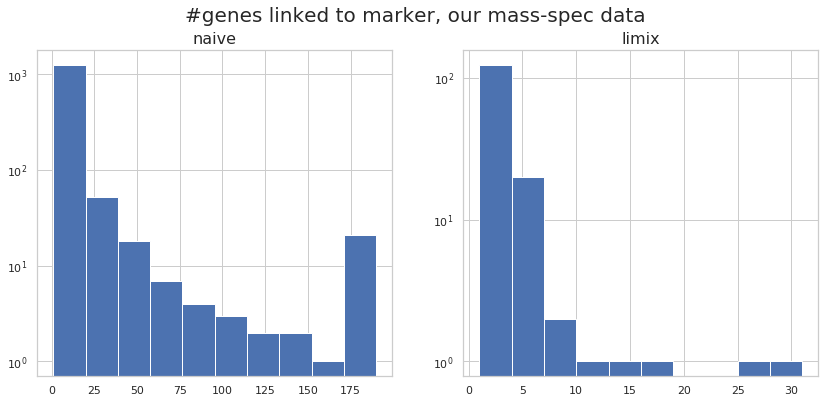

In [51]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(14, 6))
fig.suptitle("#genes linked to marker, our mass-spec data", fontsize=20)
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].hist(Counter(qtls_df["pQTLs_2011"]["SNP"]).values());
axes[0].set_title("naive", fontsize=16)
axes[0].set_yscale("log")
axes[1].hist(Counter(limix_qtls_df["SNP"]).values())
axes[1].set_title("limix", fontsize=16)
axes[1].set_yscale("log")

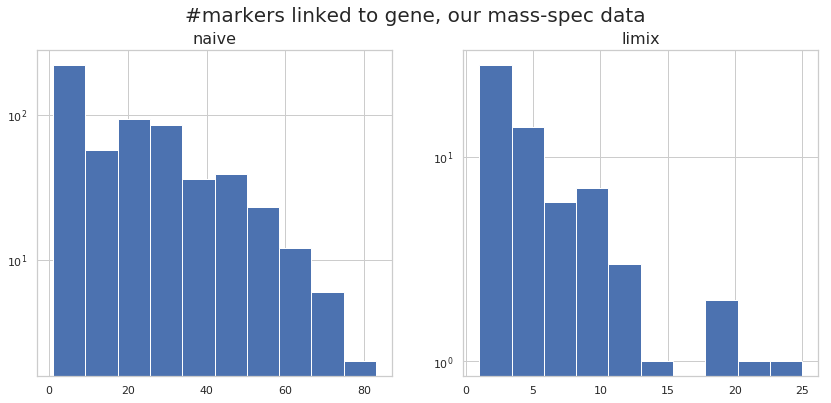

In [52]:
gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(14, 6))
fig.suptitle("#markers linked to gene, our mass-spec data", fontsize=20)
axes = [plt.subplot(gs[i]) for i in range(2)]
axes[0].hist(sorted(Counter(qtls_df["pQTLs_2011"]["gene"]).values())[:-4]);
axes[0].set_title("naive", fontsize=16)
axes[0].set_yscale("log")
axes[1].hist(Counter(limix_qtls_df["gene"]).values())
axes[1].set_title("limix", fontsize=16)
axes[1].set_yscale("log")

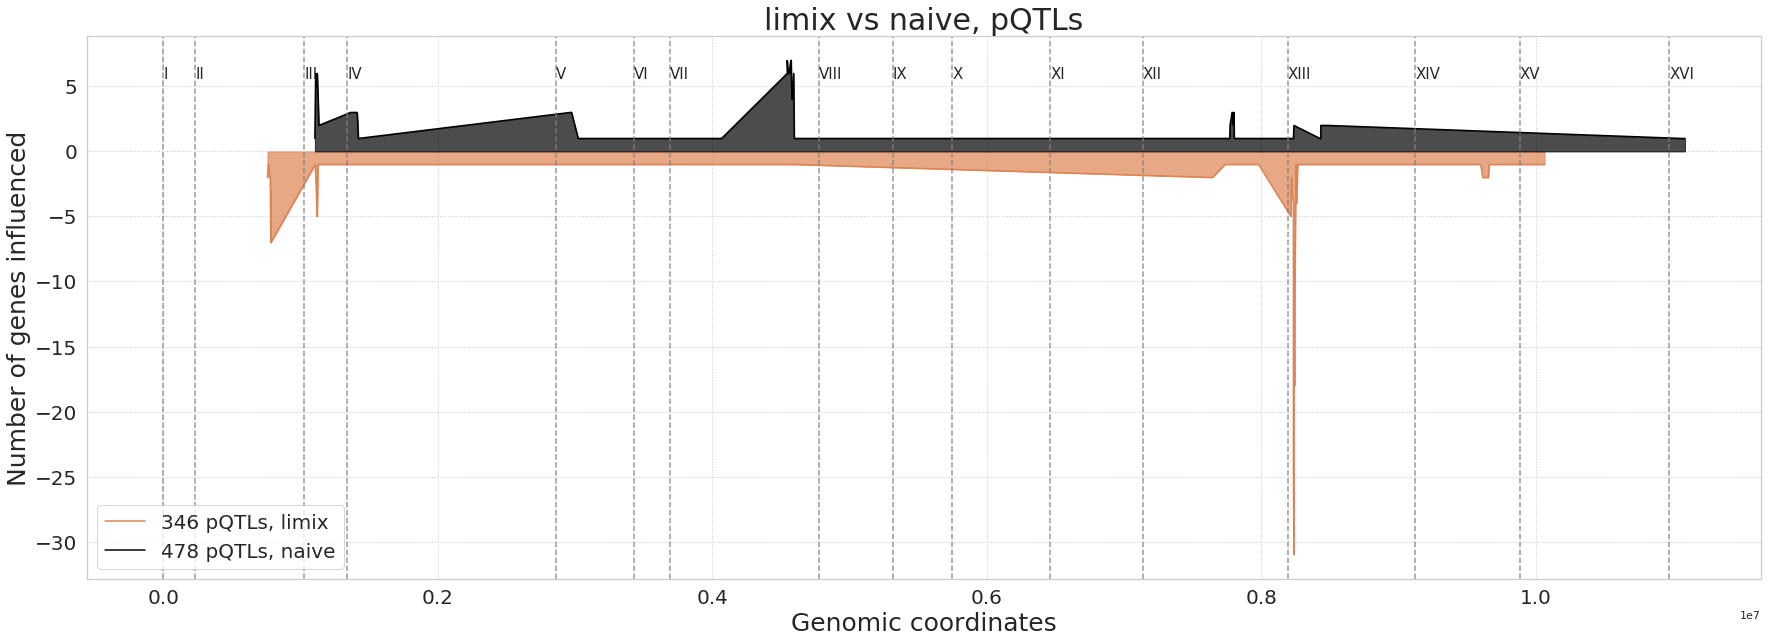

In [53]:
""" Plot the distributions of each QTL dataset"""

sns.set(style="whitegrid")


q_value_threshold = 1e-8
with open("./data/raw/genomic_features/order_of_markers.pkl", "rb") as pickle_file:
    marker2location = pickle.load(pickle_file)
with open("./data/raw/genomic_features/chromosome_endpoints.pkl",
          "rb") as pickle_file:
    chromosome_endpoints = pickle.load(pickle_file)
    
limix_pQTL_markers, limix_pQTL_y = qtls.linkages2gencoords(limix_qtls_df)
old_pQTL_markers, old_pQTL_y = qtls.linkages2gencoords(
    qtls_df["pQTLs_2011"]\
    .query("q_value <= {}"\
           .format(q_value_threshold))
)

old_pQTL_x = list(map(marker2location.get, old_pQTL_markers))
limix_pQTL_x = list(map(marker2location.get, limix_pQTL_markers))

colors_dict = dict(
    zip([
        "eQTLs_2011", "pQTLs_limix", "eQTLs_2018"
    ], plt.rcParams['axes.prop_cycle'].by_key()['color'][:3]))

colors_dict["pQTLs_2011"] = "black"
plt.figure(figsize=(30, 10))
plt.title(
    "limix vs naive, pQTLs",
    fontsize=30)
for n in range(1, 17):
    plt.axvline(
        x=chromosome_endpoints[n - 1], linestyle='--', color='grey', alpha=0.8)
    plt.text(
        chromosome_endpoints[n - 1],
        0.8 * np.max(old_pQTL_y),
        util.as_roman(n),
        fontsize=15)

plt.plot(
    limix_pQTL_x,
    -limix_pQTL_y,
    label="{} pQTLs, limix".format(limix_qtls_df.shape[0]),
    alpha=1,
    color=colors_dict["pQTLs_limix"],
    zorder=1)
plt.fill_between(
    limix_pQTL_x, 
    -limix_pQTL_y, 0, 
    alpha=0.7, 
    color=colors_dict["pQTLs_limix"]
)


plt.plot(
    old_pQTL_x,
    old_pQTL_y,
    label="{} pQTLs, naive".format(qtls_df["pQTLs_2011"]\
    .query("q_value <= {}"\
           .format(q_value_threshold)).shape[0]),
    alpha=1,
    color=colors_dict["pQTLs_2011"],
    zorder=1)
plt.fill_between(
    old_pQTL_x, 0, 
    old_pQTL_y, alpha=0.7, 
    color=colors_dict["pQTLs_2011"]
)


plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of genes influenced", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc=3)
plt.grid(linestyle="dotted")
# plt.savefig("img/qtl_distributions/corrected_limix_vs_A&B_2018.png", dpi=300)
plt.show()
plt.close()